### Bar Crawl Exercise


## Setup

Import packages and load data. I used {get reference] to convert the original .csv files into .ftr (feather) to reduce size and load times. 

In [1]:
import numpy as np
import pandas as pd

from scipy.signal import spectrogram
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

from os import listdir, walk, environ
from os.path import isfile, join

import re as re

In [2]:
import sys

In [3]:
# kaggle datasets download -d nautiyalamit/bar-crawl-detecting-heavy-drinking-data-set

In [4]:
datafolder = 'feather_data'
acc_datafile = 'all_accelerometer_data_pids_13.ftr'
phone_datafile = 'phone_types.ftr'

all_acc_df = pd.read_feather(join(datafolder, acc_datafile))
phones_df = pd.read_feather(join(datafolder, phone_datafile))

In [5]:
phones_df

,pid,phonetype
0,BK7610,iPhone
1,BU4707,iPhone
2,CC6740,Android
3,DC6359,iPhone
4,DK3500,iPhone
5,HV0618,iPhone
6,JB3156,Android
7,JR8022,iPhone
8,MC7070,iPhone
9,MJ8002,iPhone


In [6]:
# make a dictionary of TAC files with keys being subject PIDs
# # pattern = re.compile(r'\D{2}\d{4}')
# pattern = re.compile(r'\D{2}\d{4}')
# tac_files = [filename if re.match(r'\D{2}\d{4}',filename) for filename in listdir(datafolder)].sort()

tac_files = sorted([filename for filename in listdir(datafolder) if re.match(r'\D{2}\d{4}',filename)])
pid_list = [filename[0:6] for filename in tac_files]

tac_df = {}

for tac_file in tac_files:
    pid = tac_file[0:6]
    if tac_file.endswith('.ftr'):
        tac_df[pid] = pd.read_feather(join(datafolder, tac_file))
    elif tac_file.endswith('.csv'):
        tac_df[pid] = pd.read_csv(join(datafolder, tac_file))
    else:
        print('%s is neither a .csv or .ftr' % tac_file)

In [7]:
acc_df = {}

for pid in pid_list:
    acc_df[pid] = all_acc_df[all_acc_df.pid==pid].reset_index().drop(columns = 'index')

## Initial inspection

Notes:

 - acceleration time stamps in milliseconds sampled nominally at 40 Hz
 - some subjects' acceleration data starts with a spurious zero reading
 - TAC time stamps in seconds

In [8]:
for pid in pid_list:
    print(acc_df[pid].head(2))

            time     pid         x       y       z
0  1493735870653  BK7610  0.126099 -0.0078 -0.0243
1  1493735870679  BK7610  0.133545 -0.0697 -0.0446
            time     pid         x       y       z
0  1493737404780  BU4707 -0.009399  0.0147  0.0186
1  1493737404807  BU4707 -0.000100  0.0126  0.0168
            time     pid         x         y         z
0              0  CC6740  0.000000  0.000000  0.000000
1  1493740580198  CC6740  0.019653 -0.007789  0.168013
            time     pid         x       y       z
0  1493736440950  DC6359  0.000300 -0.0001  0.0038
1  1493736440969  DC6359  0.004501 -0.0085 -0.0069
            time     pid       x       y       z
0  1493744709881  DK3500  0.0000  0.0021  0.0153
1  1493744709905  DK3500 -0.0014  0.0003  0.0145
            time     pid         x       y       z
0  1493738907489  HV0618  0.010399  0.0098  0.0149
1  1493738907513  HV0618 -0.014801 -0.0178  0.0066
            time     pid         x         y          z
0              0  JB

In [9]:
for pid in pid_list:
    print(tac_df[pid].head(2))

    timestamp  TAC_Reading
0  1493718714    -0.000482
1  1493720697     0.001573
    timestamp  TAC_Reading
0  1493718714    -0.000482
1  1493720697     0.001573
    timestamp  TAC_Reading
0  1493723434     0.003948
1  1493725257     0.000898
    timestamp  TAC_Reading
0  1493719224    -0.002079
1  1493721045     0.000898
    timestamp  TAC_Reading
0  1493727820     0.000215
1  1493728019     0.001716
    timestamp  TAC_Reading
0  1493721779    -0.001077
1  1493723604     0.004120
    timestamp  TAC_Reading
0  1493722816     0.002388
1  1493724639     0.000271
    timestamp  TAC_Reading
0  1493721062     0.000068
1  1493722885    -0.012199
    timestamp  TAC_Reading
0  1493719652    -0.003151
1  1493721476     0.000554
    timestamp  TAC_Reading
0  1493720054    -0.001385
1  1493721878     0.000864
    timestamp  TAC_Reading
0  1493717859     0.000043
1  1493720213     0.003820
    timestamp  TAC_Reading
0  1493716723    -0.010231
1  1493718546    -0.002512
    timestamp  TAC_Reading
0

In [ ]:
fig, ax = plt.subplots(3,5, figsize=(15,10))


for k, pid in enumerate(pid_list):
    acc_df[pid].plot(x='time', y = 'x', marker = '.', linestyle = 'none', ax = ax[k%3, int(np.floor(k/3))])
    ax[k%3, int(np.floor(k/3))].set_title(pid)
    
fig.set_title('x acceleration data')
plt.show()

AttributeError: 'Figure' object has no attribute 'set_title'

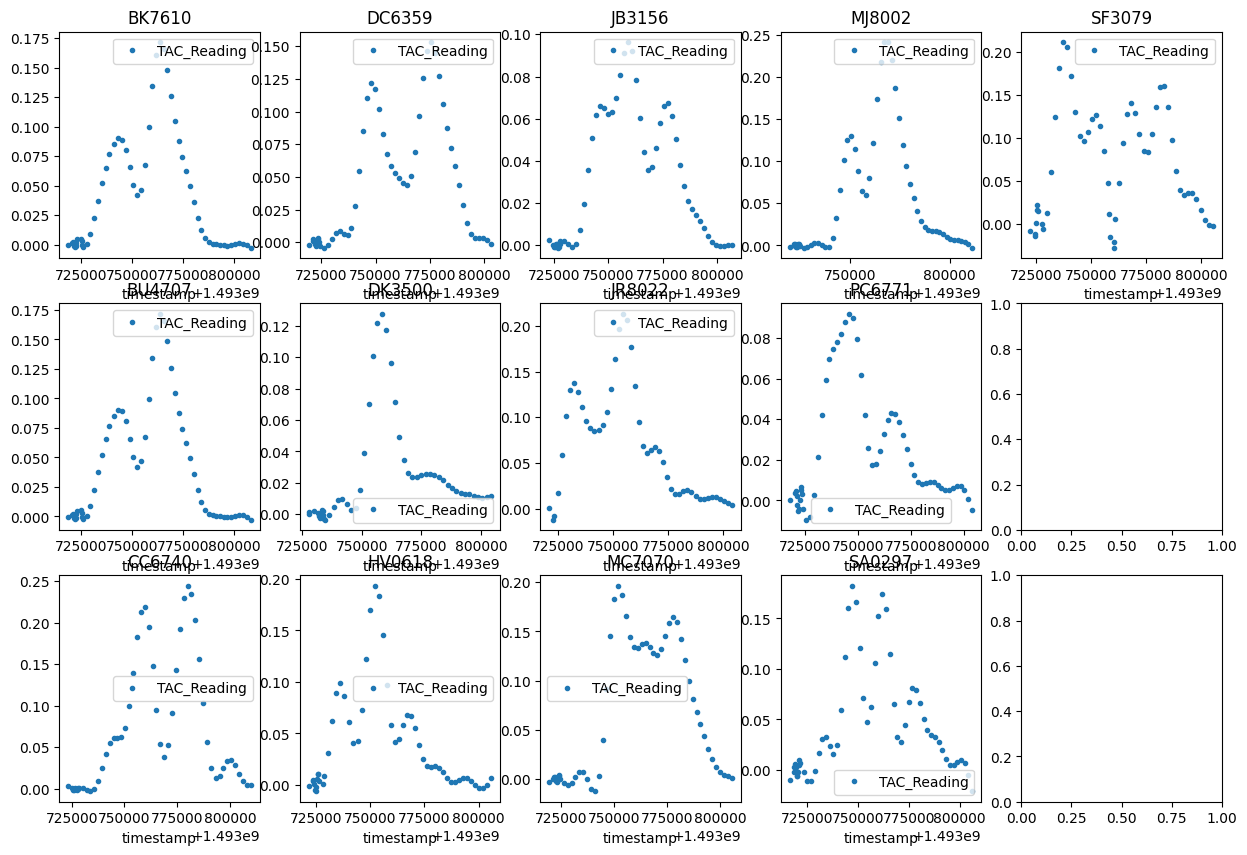

In [35]:
fig, ax = plt.subplots(3,5, figsize=(15,10))


for k, pid in enumerate(pid_list):
    tac_df[pid].plot(x='timestamp', y = 'TAC_Reading', marker = '.', linestyle = 'none', ax = ax[k%3, int(np.floor(k/3))])
    ax[k%3, int(np.floor(k/3))].set_title(pid)
    
fig.set_title('TAC Data')
plt.show()

#### Observations

 - every subject has patches of missing data
 - subjects JB3156, CC6740, and possibly others are unusable.
 - TAC 

## Clean up and reorganizing data
